# 4. RetinaNet


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/object-detection/Ch4-RetinaNet.ipynb)

In [ ]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/rkHc_Tzn810" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')



3장에서는 제공된 데이터에 augmentation을 가하는 방법과 데이터셋 클래스를 만드는 방법을 확인했습니다. 이번 장에서는 torchvision에서 제공하는 one-stage 모델인 RetinaNet을 활용해 의료용 마스크 검출 모델을 구축해보겠습니다. 

4.1절부터 4.3절까지는 2장과 3장에서 확인한 내용을 바탕으로 데이터를 불러오고 훈련용, 시험용 데이터로 나눈 후 데이터셋 클래스를 정의하겠습니다. 4.4절에서는 torchvision API를 활용하여 사전 훈련된 모델을 불러오겠습니다. 4.5절에서는 전이 학습을 통해 모델 학습을 진행한 후 4.6절에서 예측값 산출 및 모델 성능을 확인해보겠습니다. 

## 4.1 데이터 다운로드

모델링 실습을 위해 2.1절에 나온 코드를 활용하여 데이터를 불러오겠습니다.

In [1]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 7), reused 13 (delta 3), pack-reused 0
Unpacking objects: 100% (27/27), done.
Face Mask Detection.zip is done!


## 4.2 데이터 분리

3.3절에서 확인한 데이터 분리 방법을 활용하여 데이터를 분리하겠습니다. 

In [2]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


## 4.3 데이터셋 클래스 정의


파이토치 모델을 학습시키기 위해선 데이터셋 클래스를 정의해야 합니다. torchvision에서 제공하는 객체 탐지 모델을 학습시키기 위한 데이터셋 클래스의 `__getitem__` 메서드는 이미지 파일과 바운딩 박스 좌표를 반환 합니다. 데이터셋 클래스를 3장에서 활용한 코드를 응용해 아래와 같이 정의 하겠습니다. 

In [172]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os

def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        # tensor로 변경
        img = to_tensor(img)


        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset('images/')
test_dataset = MaskDataset('test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

최종적으로 훈련용 데이터와 시험용 데이터를 batch 단위로 불러올 수 있게 `torch.utils.data.DataLoader` 함수를 활용해 `data_loader`와 `test_data_loader`를 각각 정의합니다. 

## 4.4 모델 불러오기


`torchvision`에서는 각종 컴퓨터 비전 문제를 해결하기 위한 딥러닝 모델을 쉽게 불러올 수 있는 API를 제공합니다. `torchvision.models` 모듈을 활용하여 RetinaNet 모델을 불러오도록 하겠습니다. RetinaNet은 `torchvision` 0.8.0 이상에서 제공되므로, 아래 코드를 활용하여 `torchvision` 버전을 맞춰줍니다.

In [4]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 7.6MB 11.7MB/s 


In [5]:
import torchvision
import torch

In [6]:
torchvision.__version__

'0.8.1+cu101'

`torchvision.__version__` 명령어를 통해 현재 cuda 10.1 버전에서 작동하는 `torchvision` 0.8.1 버전이 설치 됐음을 확인할 수 있습니다. 다음으로는 아래 코드를 실행하여 RetinaNet 모델을 불러옵니다. Face Mask Detection 데이터셋에 3개의 클래스가 존재하므로 num_classes 매개변수를 3으로 정의하고, 전이 학습을 할 것이기 때문에 backbone 구조는 사전 학습 된 가중치를, 그 외 가중치는 초기화 상태로 가져옵니다. backbone은 객체 탐지 데이터셋으로 유명한 COCO 데이터셋에 사전 학습 됐습니다.

In [7]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## 4.5 전이 학습

모델을 불러왔으면 아래 코드를 활용하여 전이 학습을 진행합니다.

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 30
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # gradient calculation이 필요한 params만 추출
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

# epoch 당 약 4분 소요
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses 
    print(epoch_loss, f'time: {time.time() - start}')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(285.5480, device='cuda:0', grad_fn=<AddBackward0>) time: 260.3005840778351
tensor(269.7547, device='cuda:0', grad_fn=<AddBackward0>) time: 259.8814558982849
tensor(256.2033, device='cuda:0', grad_fn=<AddBackward0>) time: 258.40376353263855
tensor(223.4201, device='cuda:0', grad_fn=<AddBackward0>) time: 259.45236992836
tensor(164.9849, device='cuda:0', grad_fn=<AddBackward0>) time: 260.89496898651123
tensor(113.9005, device='cuda:0', grad_fn=<AddBackward0>) time: 261.29509234428406
tensor(91.3327, device='cuda:0', grad_fn=<AddBackward0>) time: 261.9590702056885
tensor(78.5606, device='cuda:0', grad_fn=<AddBackward0>) time: 261.2914078235626
tensor(76.6766, device='cuda:0', grad_fn=<AddBackward0>) time: 262.0534381866455
tensor(70.1354, device='cuda:0', grad_fn=<AddBackward0>) time: 261.97524547576904
tensor(62.1639, device='cuda:0', grad_fn=<AddBackward0>) time: 262.1178023815155
tensor(57.4155, device='cuda:0', grad_fn=<AddBackward0>) time: 262.0588939189911
tensor(55.3569, devi

모델 재사용을 위해 아래 코드를 실행하여 학습된 가중치를 저장해줍니다. `torch.save` 함수를 활용해 지정한 위치에 학습된 가중치를 저장할 수 있습니다.

In [ ]:
torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')

In [18]:
retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))

<All keys matched successfully>

학습된 가중치를 불러올 때는 `load_state_dict`과 `torch.load`함수를 사용하면 됩니다. 만약 retina 변수를 새롭게 지정했을 경우, 해당 모델을 GPU 메모리에 올려주어야 GPU 연산이 가능합니다. 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

## 4.6 예측

훈련이 마무리 되었으면, 예측 결과를 확인하도록 하겠습니다. test_data_loader에서 데이터를 불러와 모델에 넣어 학습 후, 예측된 결과와 실제 값을 각각 시각화 해보도록 하겠습니다. 우선 예측에 필요한 함수를 정의하겠습니다.

In [20]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #threshold 넘는 idx 구함
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

`make_prediction` 함수에는 학습된 딥러닝 모델을 활용해 예측하는 알고리즘이 저장돼 있습니다. `threshold` 파라미터를 조정해 신뢰도가 일정 수준 이상의 바운딩 박스만 선택합니다. 보통 0.5 이상인 값을 최종 선택합니다. 다음으로는 for문을 활용해 `test_data_loader`에 있는 모든 데이터에 대해 예측을 실시하겠습니다.

In [25]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 85/85 [00:27<00:00,  3.08it/s]


`tqdm` 함수를 활용해 진행 상황을 표츌하고 있습니다. 예측된 모든 값은 `preds_adj_all` 변수에 저장됐습니다. 다음으로는 실제 바운딩 박스와 예측한 바운딩 박스에 대한 시각화를 진행해보겠습니다.

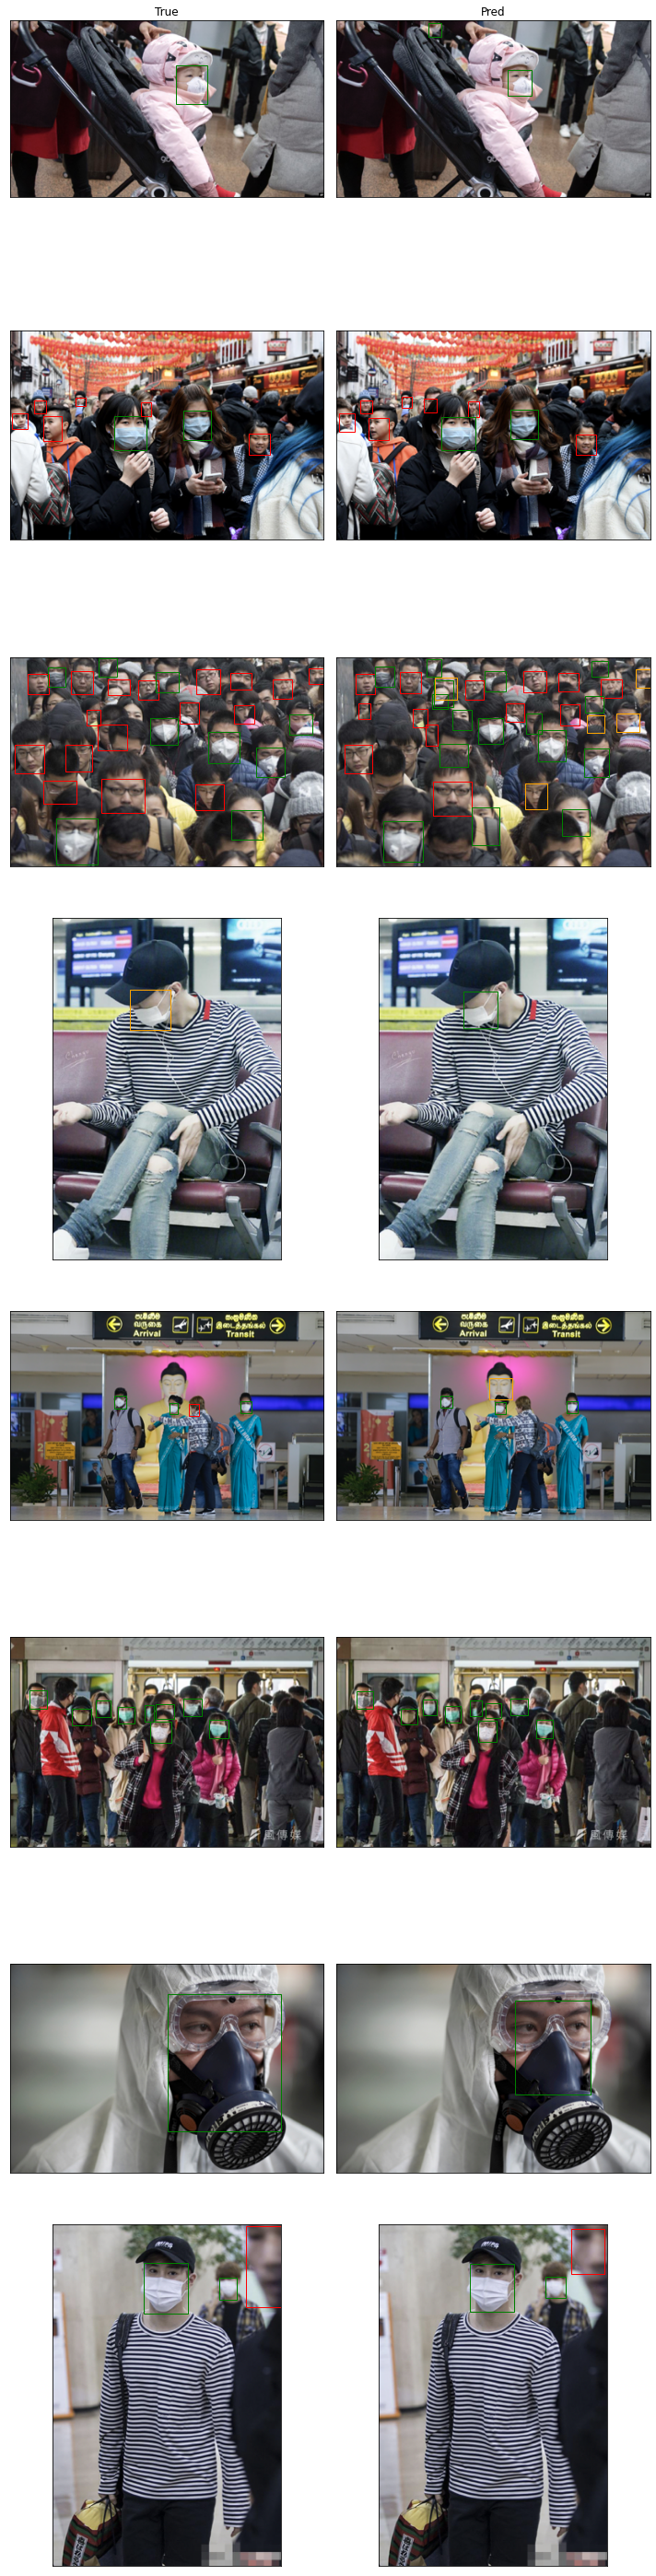

In [176]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))

batch_i = 0
for im, annot in test_data_loader:
    pos = batch_i * 4 + 2
    for sample_i in range(len(im)) :
        
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos-1)//2, 1-((pos-1)%2)].imshow(img)
        for rect in rects:
            axes[(pos-1)//2, 1-((pos-1)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos-1)//2, 1-(pos%2)].imshow(img)
        for rect in rects:
            axes[(pos-1)//2, 1-(pos%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

for문을 활용해 4개의 batch, 총 8개의 이미지에 대한 실제 값과 예측 값을 시각해 보았습니다. 왼쪽 열이 실제 바운딩 박스의 라벨과 위치이며 오른쪽 열이 모델의 예측 값입니다. 마스크 착용자(초록색)는 잘 탐지하고 있는 것을 관측하고 있으며, 마스크 미착용자(빨간색)에 대해서는 가끔씩 마스크를 올바르지 않게 착용한 것(주황색)으로 탐지한 것을 볼 수 있습니다. 전반적인 모델 성능을 평가하기 위해 mean Average Precision (mAP)를 산출해보겠습니다. mAP는 객체 탐지 모델을 평가할 때 사용하는 지표입니다.

데이터 다운로드시 불러왔던 Tutorial-Book-Utils 폴더 내에는 utils_ObjectDetection.py 파일이 있습니다. 해당 모듈 내에 있는 함수를 활용해 mAP를 산출해보겠습니다. 우선 utils_ObjectDetection.py 모듈을 불러옵니다.

In [27]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [28]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

batch 별 mAP를 산출하는데 필요한 정보를 `sample_metrics`에 저장 후 `ap_per_class`함수를 활용해 mAP를 산출합니다. 

In [29]:
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.5824690281035101
AP : tensor([0.7684, 0.9188, 0.0603], dtype=torch.float64)


결과를 해석하면 0번 클래스인 마스크를 미착용한 객체에 대해서는 0.7684 AP를 보이며 1번 클래스인 마스크 착용 객체에 대해서는 0.9188 AP를 보이고, 2번 클래스인 마스크를 올바르게 착용하지 않은 객체에 대해서는 0.06 AP를 보입니다.

지금까지 RetinaNet에 대한 전이 학습을 실시해 의료용 마스크 탐지 모델을 만들어 보았습니다. 다음 장에서는 Two-Stage Detector인 Faster R-CNN을 활용해 탐지 성능을 높여보겠습니다. 